Neural Network Code

CIS 481/581 Computational Learning

Instructor: Luis E Ortiz

In [1]:
import math
import copy
import numpy as np
import matplotlib.pyplot as plt
import warnings

from collections import defaultdict

from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import ParameterGrid, KFold, train_test_split

from numpy.random import default_rng

In [2]:
rng = default_rng()

def random_uniform(n,m,R=[-1.0,1.0]):
  a, b = R[0], R[1]
  return (b - a) * rng.random((n,m)) + a

def sigmoid(x):
  return 1.0 / (1.0 + np.exp(-x))

def deriv_sigmoid(x):
  return sigmoid(x) * (1.0 - sigmoid(x))

def squared_error(y_true,y_pred):
  return 0.5 * (y_true - y_pred) ** 2

def deriv_squared_error(y_true,y_pred):
  return y_pred - y_true

def indicator(p):
  return p.astype(int)

def error_rate(y_true, y_pred):
  return 1.0 - np.mean(indicator(y_true == y_pred))

def identity(x):
  return x

def deriv_identity(x):
  return np.ones(x.shape)

In [3]:
def make_nunits(n,K,L,N):
  nunits = [n]
  for l in range(L):
    nunits.append(N)
  nunits.append(K)
  return nunits

def time_nnet(nunits):
  t = 0
  for l in range(len(nunits)-1):
    t += (nunits[l] + 1) * nunits[l+1]
  return t

In [4]:
MAX_ITERS = 50
MAX_NHIDU = 2**9
MAX_NHIDL = 2**2
MAX_M = 2000

n= 1024
K = 10

MAX_NUNITS = make_nunits(n,K,MAX_NHIDL,MAX_NHIDU)
MAX_NNET_TIME = time_nnet(MAX_NUNITS)

MAX_TIME = MAX_M * MAX_NNET_TIME * MAX_ITERS


In [5]:
class NNetBaseFunction:
    def __init__(self, f=None,df=None):
      self.f = f
      self.df = df 

    def deepcopy(self):
      return NNetBaseFunction(f=self.f, df=self.df) 

In [6]:
class NNetActivation(NNetBaseFunction):
    def __init__(self, f=sigmoid,df=deriv_sigmoid):
      super().__init__(f=f,df=df)

    def deepcopy(self):
      return NNetActivation(f=self.f, df=self.df) 

In [7]:
class NNetLoss(NNetBaseFunction):
  def __init__(self, f=squared_error,df=deriv_squared_error):
    super().__init__(f=f,df=df)

  def deepcopy(self):
    return NNetLoss(f=self.f, df=self.df)

In [8]:
class NNetMetric(NNetBaseFunction):
  def __init__(self, f=error_rate):
    super().__init__(f=f,df=None)

  def deepcopy(self):
    return NNetMetric(f=self.f)

In [9]:
class NNetLayer:
  def __init__(self,n_in=1,n_out=1,W=None,
               unit=NNetActivation(), initializer=random_uniform):
    self.n_in = n_in
    self.n_out = n_out
    if initializer is None:
      initializer =  lambda n, m : np.zeros((n,m))
    self.initializer = initializer
    if W is None:
      W = self.initializer(n_out,n_in+1)
    else: 
      self.n_in, self.n_out = W.shape[1]-1, W.shape[0]
    self.W = W
    self.unit = unit

  def ds(self, x):
    return self.unit.df(x)

  def deepcopy(self):
    return NNetLayer(n_in=self.n_in,n_out=self.n_out,W=self.W.copy(),
                     unit=self.unit)

  def copy_layer(self, layer):
    self.W[:] = layer.W[:]
    return self

  # assumes x[0,:] = +1
  def aggregation_with_dummy_input(self, x):
    return np.matmul(self.W,x)

  def aggregation(self, x):
    if x.shape[0] == self.W.shape[1]:
      x_tmp = x
    else: 
      x_tmp = np.ones(W.shape[1],x.shape[1])
      x_tmp[1:,:] = x
    return self.aggregation_with_dummy_input(x_tmp)

  def activation(self, x):
    return self.unit.f(self.aggregation(x))

  def set_x(self, x):
    return x

  def set_y(self, y):
    return y

  def get_y(self):
    return None
  

In [10]:
class NNetIdentityLayer (NNetLayer):
  def __init__(self,n_in=1,n_out=1,W=None):
    super().__init__(n_in=n_in,n_out=n_out,W=W,
                     unit=NNetActivation(identity,deriv_identity))

In [11]:
class NNetLayerProp(NNetLayer):
  def __init__(self,n_in=1,n_out=1,W=None,
               unit=NNetActivation(sigmoid,deriv_sigmoid),m=1):
    super().__init__(n_in=n_in,n_out=n_out,W=W,unit=unit)
    # self.y = np.ones((n_out+1,m))
    # self.y[1:,:] = 0
    # self.delta = np.zeros((n_out+1,m))
    self.x = None
    self.y = None
    self.delta = None

  def deepcopy(self):
    copy = super().deepcopy()
    # Input is not "stored" by layer
    copy.x = self.x
    copy.y = None if self.y is None else self.y.copy()
    copy.delta = None if self.delta is None else self.delta.copy()
    return copy

  def set_x(self, x):
    self.x = x
    return x

  def set_y(self, y):
    self.y = y
    return y

  def set_delta(self, delta):
    self.delta = delta
    return delta

  def get_x(self):
    return self.x

  def get_y(self):
    return self.y

  def get_delta(self):
    return self.delta

  def dW(self):
    return np.matmul(self.delta,self.x.T)

In [12]:
class NNetInputLayerProp(NNetLayerProp):
  def __init__(self,n_in=1,n_out=1,W=None,m=1):
    super().__init__(n_in=n_in,n_out=n_out,W=W,unit=NNetActivation(identity,deriv_identity))
    self.y = None

  def deepcopy(self):
    obj = super().deepcopy()
    obj.y = None if self.y is None else self.y.deepcopy()
    return obj


In [13]:
class NNetOptimizer:
  def __init__(self,loss=NNetLoss(),metric=NNetMetric()):
    self.loss = loss
    self.metric = metric
    self.best_nnet = None
    self.last_nnet = None
    self.train_err = []
    self.test_err = []
    return self

  def deepcopy(self):
    opt = NNetOptimizer(loss=self.loss.deepcopy(),metric=self.metric.deepcopy())
    opt.best_nnet = None if self.best_nnet is None else self.best_nnet.deepcopy()
    opt.last_nnet = None if self.best_nnet is None else self.last_nnet.deepcopy()
    opt.train_err = self.train_err.deepcopy()
    opt.test_err = self.test_err.deepcopy()
    return opt

  def run(self,nnet,X,y):
    return self.best_nnet

In [14]:
class NNet:
  def __init__(self, nunits=[0,0], unit=NNetActivation(sigmoid,deriv_sigmoid), 
               output_unit=None, Layer=NNetLayerProp, InputLayer=NNetInputLayerProp):
    self.nunits = nunits
    self.unit = unit
    self.output_unit = unit if output_unit is None else output_unit
    self.nlayers = len(nunits)
    self.layer = []
    self.layer.append(InputLayer(n_in=1,n_out=nunits[0]))

    for l in range(1,self.nlayers-1):
      self.layer.append(Layer(n_in=nunits[l-1],n_out=nunits[l],unit=unit))

    self.layer.append(Layer(n_in=nunits[-2],n_out=nunits[-1],
                                unit=self.output_unit))

  def copy(self, nnet_copy=None, Layer=NNetLayerProp, InputLayer=NNetInputLayerProp):
    if nnet_copy is None:
      nnet_copy = NNet(nunits=self.nunits,unit=self.unit,output_unit=self.output_unit, Layer=Layer, InputLayer=InputLayer)
    nnet_copy.copy_layers(self)
    return nnet_copy

  def deepcopy(self, nnet_copy=None):
    nnet_copy = self.copy(nnet_copy=nnet_copy)

    nnet_copy.nunits = copy.deepcopy(self.nunits)
    nnet_copy.unit = self.unit.deepcopy()
    nnet_copy.output_unit = self.output_unit.deepcopy()

    for l in range(1,self.nlayers):
      nnet_copy.layer[l] = self.layer[l].deepcopy()

    return nnet_copy

  def copy_layers(self, nnet_copy_from):
    for l in range(self.nlayers):
      self.layer[l].copy_layer(nnet_copy_from.layer[l])
    return self

  def error(self, X, y, loss=squared_error, metric=None):
    output = self.forwardprop(X.T)
    err = np.mean(loss(y.T, output))
    err_rate = 1.0 if metric is None else metric(y.T,output)
    return err, err_rate

  def forwardprop(self,X):
    m = X.shape[1]
    out_vals = np.ones((X.shape[0]+1,m))
    out_vals[1:,:] = X
    self.layer[0].set_y(out_vals)

    for l in range(1,self.nlayers):
      self.layer[l].set_x(self.layer[l-1].get_y())
      del out_vals
      out_vals = np.ones((self.nunits[l]+1,m))
      out_vals[1:,:] = self.layer[l].activation(self.layer[l].get_x())
      self.layer[l].set_y(out_vals)

    return out_vals[1:,:]

  def backprop(self,X,y,dE='deriv_squared_error'):
    net_output = self.forwardprop(X)

    layer = self.layer[self.nlayers-1]
    layer.set_delta(layer.ds(net_output) * dE(y,net_output))

    for l in range(self.nlayers-1,1,-1):
      next_layer = self.layer[l]
      layer = self.layer[l-1]
      x = layer.get_y()[1:,:]
      d = next_layer.delta
      layer.set_delta(layer.ds(x) * np.matmul(next_layer.W[:,1:].T,d))

    dW = []
    for l in range(self.nlayers):
      dW.append(None)

    for l in range(self.nlayers-1,0,-1):
      dW[l] = self.layer[l].dW() 

    return dW

  def fit(self, X, y, X_test=None, y_test=None, optimizer=None, verbose=0):
    if optimizer is None:
      optimizer = NNetGDOptimizer(loss=NNetLoss())

    best_nnet = optimizer.run(self,X,y,X_test,y_test,verbose)

    self.copy_layers(best_nnet)

    return self


In [15]:
class NNetGDOptimizer(NNetOptimizer):
  def __init__(self,loss=NNetLoss(),max_iters=100, learn_rate=1, reg_param=0, 
               change_thresh=1e-4, change_err_thresh=1e-6,metric=NNetMetric()):
    super().__init__(loss=loss,metric=metric)
    self.max_iters = max_iters
    self.learn_rate = learn_rate
    self.reg_param = reg_param
    self.change_thresh = change_thresh
    self.change_err_thresh = change_err_thresh

  def deepcopy(self):
    opt = super().deepcopy()
    return NNetGDOptimizer(loss=opt.loss, max_iters=self.max_iters, learn_rate=self.learn_rate, reg_param=self.reg_param, 
               change_thresh=self.change_thresh, change_err_thresh=self.change_err_thresh,metric=opt.metric)

  def run(self, nnet, X, y, X_test=None, y_test=None, verbose=0):

    eval_test = X_test is not None and y_test is not None
    new_nnet = NNet(nunits=nnet.nunits,unit=nnet.unit,output_unit=nnet.output_unit,Layer=NNetLayerProp,InputLayer=NNetInputLayerProp)
    new_nnet.copy_layers(nnet)

    t = 0
    max_change = math.inf
    min_change_err = math.inf

    train_err = []
    test_err = []

    err, err_rate = new_nnet.error(X, y, loss=self.loss.f, metric=self.metric.f)
    if verbose > 0:
      print((err,err_rate))
    min_err, min_err_rate = err, err_rate
 
    if eval_test:
      cv_err,cv_err_rate = new_nnet.error(X_test, y_test, loss=self.loss.f, metric=self.metric.f)

    best_nnet = nnet.deepcopy()
    best_nnet.copy_layers(new_nnet)

    while min_change_err > self.change_err_thresh and max_change > self.change_thresh and t < self.max_iters:
      if verbose > 0:
        print(t)
        print("Backprop...")

      dW = new_nnet.backprop(X.T, y.T,dE=self.loss.df)
      
      if verbose > 0:
        print("done.")
        print("Update...")

      max_change = 0

      for l in range(new_nnet.nlayers-1,0,-1):
        delta_W = self.learn_rate * (dW[l] / m + self.reg_param * new_nnet.layer[l].W)
        new_nnet.layer[l].W[:] = new_nnet.layer[l].W[:] - delta_W[:]
        max_change = max(max_change, np.max(np.absolute(delta_W)))

      del dW[:]

      if verbose > 0:
        print("done.")

      last_err = err
      err,err_rate = new_nnet.error(X, y, loss=self.loss.f, metric=self.metric.f)
      if verbose > 0:
        print((err,err_rate))
      min_change_err = np.absolute(err-last_err)


      if verbose > 0:
        print("max_change")
        print(max_change)

      if eval_test:
        cv_err,cv_err_rate = new_nnet.error(X_test, y_test, loss=self.loss.f, metric=self.metric.f)

      if verbose > 0:
        if eval_test:
          print("(test_err,test_err_rate)")
          print((cv_err,cv_err_rate))

      if err < min_err:
        min_err = err
        min_err_rate = err_rate
        best_nnet.copy_layers(new_nnet)

      t += 1

      train_err.append([err, err_rate])
      if eval_test:
        test_err.append([cv_err, cv_err_rate])

    if verbose > 0:
      if eval_test:
        print("(best_train_err,best_train_err_rate)")
        print((min_err,min_err_rate))

    self.train_err = train_err
    self.test_err = test_err

    return best_nnet

In [30]:
# D = np.loadtxt("drive/MyDrive/CIS_481_581_Computational_Learning/project_2_files_share/optdigits_train.dat")
# D_test = np.loadtxt("drive/MyDrive/CIS_481_581_Computational_Learning/project_2_files_share/optdigits_test.dat")
# D_trial = np.loadtxt("drive/MyDrive/CIS_481_581_Computational_Learning/project_2_files_share/optdigits_trial.dat")
D = np.loadtxt("../data/optdigits_train.dat")
D_test = np.loadtxt("../data/optdigits_test.dat")
D_trial = np.loadtxt("../data/optdigits_trial.dat")

In [31]:
m, n = D.shape[0], D.shape[1]-1

X = D[:,:-1].reshape(m,n)
y = D[:,-1].reshape(m,1)

out_enc = LabelBinarizer()
y_ohe = out_enc.fit_transform(y)

K = y_ohe.shape[1]

m_test = D_test.shape[0]

X_test = D_test[:,:-1].reshape(m_test,n)
y_test = D_test[:,-1].reshape(m_test,1)

y_test_ohe = out_enc.transform(y_test)

m_trial = D_test.shape[0]

X_trial = D_test[:,:-1].reshape(m_trial,n)
y_trial = D_test[:,-1].reshape(m_trial,1)

y_trial_ohe = out_enc.transform(y_test)

[4.]


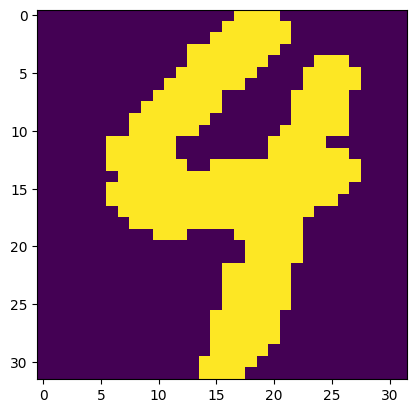

In [32]:
plt.imshow(X[53,:].reshape(32,32))
print(y[53])

[6.]


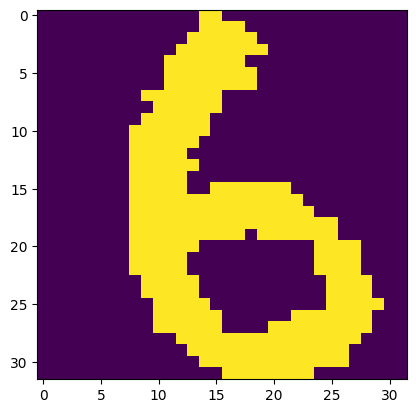

In [33]:
plt.imshow(X_trial[1,:].reshape(32,32))
print(y_trial[1])

In [34]:
def nnet_error_rate(y_true, y_pred):
  y_pred_label = np.argmax(y_pred,axis=0).reshape(-1,1)
  y_true_label = out_enc.inverse_transform(y_true.T).reshape(-1,1)
  return error_rate(y_true_label, y_pred_label)  

In [35]:
nnet_metric = NNetMetric(f=nnet_error_rate)

In [47]:
print(n)
print(K)
print(m)
print(m_test)

nnet = NNet(nunits=[n, 512, 512, 512, 512, K])

opt = NNetGDOptimizer(metric=nnet_metric, max_iters=50, learn_rate=1)

# best_nnet = nnet.fit(X[:1000,:],y_ohe[:1000,:],X_test,y_test_ohe,optimizer=opt,verbose=1)
best_nnet = nnet.fit(X,y_ohe,X_test,y_test_ohe,optimizer=opt,verbose=0)

1024
10
1934
946


C:\Users\jsteb\AppData\Local\Temp\ipykernel_2756\2068141798.py:8: RuntimeWarning: overflow encountered in exp
  return 1.0 / (1.0 + np.exp(-x))


0.5813953488372092


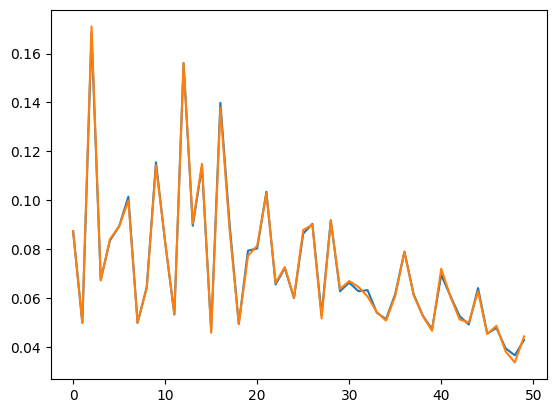

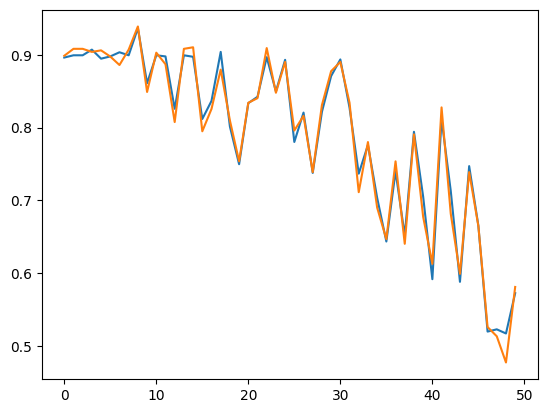

In [48]:
train_err, test_err = np.array(opt.train_err), np.array(opt.test_err)

print(test_err[-1,1])

plt.plot(train_err[:,0])
plt.plot(test_err[:,0])
plt.show()

plt.plot(train_err[:,1])
plt.plot(test_err[:,1])
plt.show()

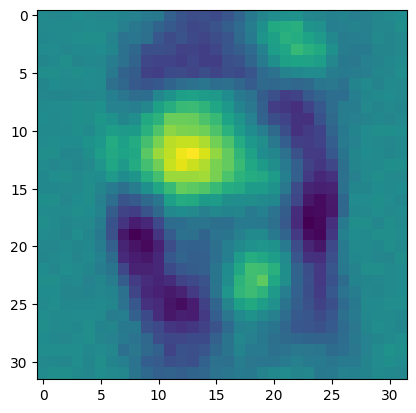

In [50]:
plt.imshow(best_nnet.layer[1].W[0,1:].reshape(32,32))
plt.show()

In [42]:
n_hidu = 64 # 512
n_hidl = 1

nunits = make_nunits(n,K,n_hidl,n_hidu)
nnet_time = time_nnet(nunits)

R = min(1000,math.ceil(MAX_TIME / (m * nnet_time)))

print(R)

1000


In [51]:
# opt = NNetGDOptimizer(metric=nnet_metric, max_iters=400, learn_rate=0.5**8)
opt = NNetGDOptimizer(metric=nnet_metric, max_iters=R, learn_rate=2**-1, change_err_thresh=0, change_thresh=0)

# nnet = NNet(nunits=[1024, 512, 512, 10],unit=NNetActivation(identity,deriv_identity),output_unit=NNetActivation(sigmoid,deriv_sigmoid))
nnet = NNet(nunits=nunits)

best_nnet = nnet.fit(X,y_ohe,X_test,y_test_ohe,optimizer=opt,verbose=0)
# est_nnet = nnet.fit(X,y_ohe,optimizer=opt,verbose=1)

0.05496828752642702


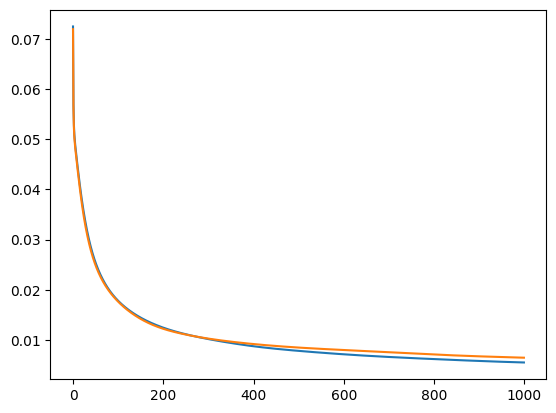

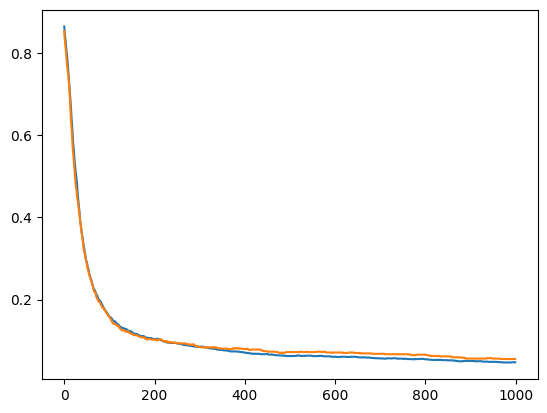

In [52]:
train_err, test_err = np.array(opt.train_err), np.array(opt.test_err)

print(test_err[-1,1])

plt.plot(train_err[:,0])
plt.plot(test_err[:,0])
plt.show()

plt.plot(train_err[:,1])
plt.plot(test_err[:,1])
plt.show()

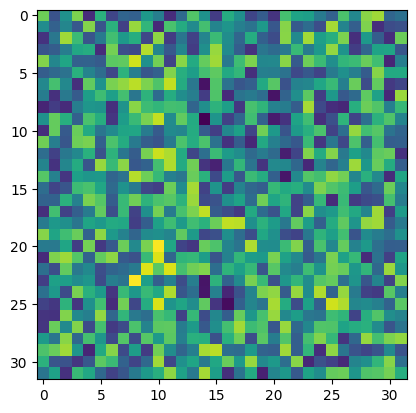

In [55]:
plt.imshow(best_nnet.layer[1].W[0,1:].reshape(32,32))
plt.show()

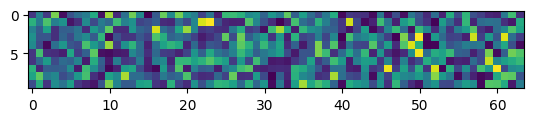

In [46]:
plt.imshow(np.absolute(best_nnet.layer[2].W[:,1:]))

# Project 2 architectures

In [73]:
# utils
def make_nnet(layers: list[int], learn_rate: float):
    nnet = NNet(nunits=layers)
    nnet_time = time_nnet(layers)
    R = min(1000,math.ceil(MAX_TIME / (m * nnet_time)))
    opt = NNetGDOptimizer(metric=nnet_metric, max_iters=R, learn_rate=learn_rate)
    
    return nnet.fit(X, y_ohe, X_test, y_test_ohe, optimizer=opt, verbose=0), opt

def graph(title: str, axes: list[str], *lines) -> None:
    for label, data in lines:
        plt.plot(data, label=label)
    plt.title(title),
    plt.xlabel(axes[0])
    plt.ylabel(axes[1])
    if len(lines) > 1:
        plt.legend()
    plt.grid()
    plt.show()

Architecture 1: multioutput perceptron

1024 -> 10, alpha in {4^i | i=0,1,2,3,4}

In [59]:
layers = [n, K]
alpha = 1

model, opt = make_nnet(layers, alpha)

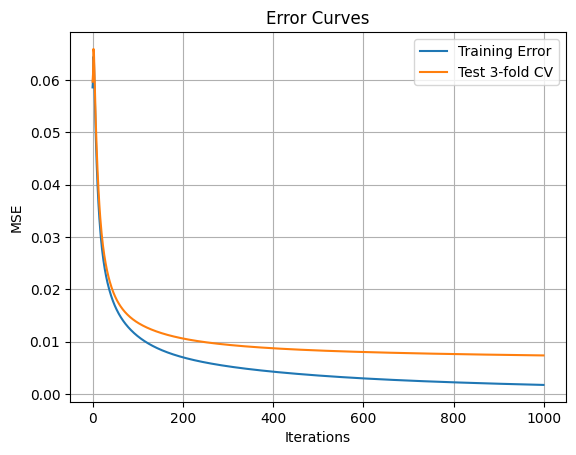

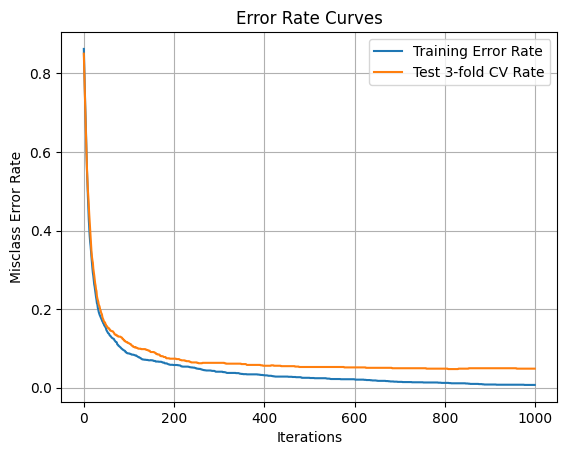

In [79]:
train_err, test_err = np.array(opt.train_err), np.array(opt.test_err)

graph('Error Curves', ['Iterations', 'MSE'],
      ['Training Error', train_err[:,0]],
      ['Test 3-fold CV', test_err[:,0]]
)

graph('Error Rate Curves', ['Iterations', 'Misclass Error Rate'],
      ['Training Error Rate', train_err[:,1]],
      ['Test 3-fold CV Rate', test_err[:,1]]
)


Architecture 2: Deep Neural Network with varying depth

1024 -> [64]*(depth in {1,2,3,4}) -> 10, alpha =1

Architecture 3: Deep Neural Network with varying learning rate

1024 -> 256 -> 64 -> 10, alpha in {4^i | i=-3,-2,-1,0,1}